<a href="https://colab.research.google.com/github/UlkuTuncerKucuktas/RedditParsing/blob/main/Parse_Reddit_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli olan kütüphanenin indirilmesi
# Kütüphane hakkında daha fazla bilgi : https://praw.readthedocs.io/en/latest/

!pip install praw


In [ ]:
# Kütüphanenin import edilmesi ve bağlantı için gerekli parametrelerin girilmesi
# Reddit API kullanarak parametreleri elde etmek için https://www.youtube.com/watch?v=NRgfgtzIhBQ
import praw

reddit = praw.Reddit(
     client_id="3M_y4OJUuFseDQ",
     client_secret="O30nQMj_DvpZiBe5SK0Uv7q9dcUgzA",
     user_agent="Erzincan",
     username="RedditParserTurk",
     password="#####"
 )
reddit.read_only = True


In [132]:
# subreddit_chosen değerini , üzerinde çalışmak istediğiniz subreddit ile değiştireblirsiniz.
# title_limit çalışacağınız subredditten çekeceğiniz submission sayısıdır.

subreddit_chosen = "cats"

title_limit = 200

In [133]:
image_url_list = []

# Reddit üzerinden belirlenen sayıda submission çeker 
# Çekilen submissionlar içerisinde url kısmını alır
# Urller içerisinde resimleri almak için jpg ve png ile bitenler haricini ayıklar
for submission in reddit.subreddit(subreddit_chosen).hot(limit=title_limit):
    if submission.url[-3:] =="jpg" or submission.url[-3:] =="png":
      image_url_list.append(submission.url)


In [134]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.pyplot import imshow
import numpy as np
from torchvision.transforms import Compose
from torchvision import transforms

# Url adreisini request kütüphanesi ile PIL image dosyasına dönüştürür
# Densenet 224,224 boyutunda RGB kabulettiğinden resimleri bu formata sokar
def url_toimage(url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img = img.resize((224,224))
  img = img.convert("RGB")
  return img

In [135]:
# Densenet içerisine sokmak için gereken diğer preprocessler
def transformsToTensor(img):
  transforms_touse = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  numarray = np.asarray(img)

  tensor = transforms_touse(numarray)

  return tensor

In [ ]:
# Densenet modelinin indirilmesi ve eval moda alınması
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
model.eval()

In [137]:
# Elde edilen tensorü modele sokar
def tensorToModel(input_batch):
  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)
  return output


In [138]:
Outputlist = []
# Modele sokmak için önceden tanımlamış fonksiyonları çağırır
for url in image_url_list:
  image = url_toimage(url)
  tensor = transformsToTensor(image)
  input_batch = tensor.unsqueeze(0)
  Outputlist.append(tensorToModel(input_batch))

In [139]:
# Imagenet classlarını içeren json dosyası
jsonurl = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

In [140]:
# json dosyasını request kütüphanesi ile alır ve model çıktısı ile
# karşılaştırabilmek için gereken formata sokar
import json
jsonobject = requests.get(jsonurl)

def modelToClass(model_output):
  value , index = torch.max(model_output,1)
  outclass =  jsonobject.json()[str(index.item())][1]

  return outclass

In [141]:
Classlist = []
# Model çıktısını json dosyasında bulunan class a dönüştürür
for tensor in Outputlist:
  outclass = modelToClass(tensor)
  Classlist.append(outclass)


In [154]:
from collections import Counter
# En çok geçen objelerin bulunması için sayım
def Sort(sub_li): 
    sub_li.sort(key = lambda x: x[1],reverse = True) 
    return sub_li 

Counted_class = Counter(Classlist)

Counted_Classlist = []

for i,j in zip(Counted_class.keys(),Counted_class.values()):
  Counted_Classlist.append([i,j])

Sorted_Class_List = Sort(Counted_Classlist)

print(Sorted_Class_List)


[['Egyptian_cat', 36], ['tabby', 21], ['Siamese_cat', 12], ['Persian_cat', 9], ['tiger_cat', 4], ['mouse', 3], ['quilt', 2], ['fur_coat', 2], ['carton', 2], ['television', 2], ['Samoyed', 2], ['doormat', 2], ['schipperke', 2], ['comic_book', 2], ['sleeping_bag', 2], ['langur', 1], ['platypus', 1], ['Cardigan', 1], ['Boston_bull', 1], ['shoe_shop', 1], ['stove', 1], ['studio_couch', 1], ['laptop', 1], ['Band_Aid', 1], ['Shetland_sheepdog', 1], ['llama', 1], ['diaper', 1], ['printer', 1], ['bath_towel', 1], ['plate_rack', 1], ['Newfoundland', 1], ['Appenzeller', 1], ['kelpie', 1], ['pajama', 1], ['sundial', 1], ['Irish_wolfhound', 1], ['apiary', 1], ['beagle', 1], ['bathtub', 1], ['paper_towel', 1], ['sliding_door', 1], ['desk', 1], ['plastic_bag', 1], ['mashed_potato', 1], ['greenhouse', 1], ['mortar', 1], ['keeshond', 1], ['Siberian_husky', 1], ['Border_collie', 1], ['iron', 1], ['dalmatian', 1]]


In [143]:
# seçilen indexte modelin tahmini ve ona verilen modeli gösterir
def showSelectedIndex(index):
  print(Classlist[index])
  img = url_toimage(image_url_list[index])
  %matplotlib inline
  imshow(np.asarray(img))



Egyptian_cat


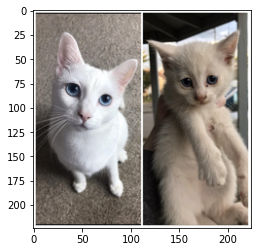

In [166]:
# 3. indexte bulunan resim ve model tahmini
showSelectedIndex(7)

In [157]:
# En çok geçen objelerin grafik ile gösterilmesi
graph_value = []
graph_label = [] 

[graph_label.append(Sorted_Class_List[x][0]) for x in range(10)]
[graph_value.append(int(Sorted_Class_List[x][1])) for x in range(10)]

print(graph_label)
print(graph_value)

['Egyptian_cat', 'tabby', 'Siamese_cat', 'Persian_cat', 'tiger_cat', 'mouse', 'quilt', 'fur_coat', 'carton', 'television']
[36, 21, 12, 9, 4, 3, 2, 2, 2, 2]


In [160]:
import pandas as pd
objectsinImages = pd.Series(graph_value,graph_label,name="")

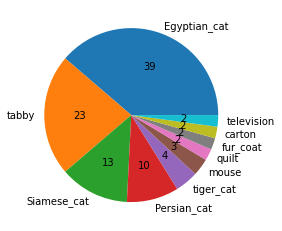

In [161]:

objectsinImages.plot.pie(autopct='%.0f')